In [1]:
import crsq.firstq as firstq
import math
m = 4
M = 2**m
Ne = 1
Na = 1
d = 1
L=2
delta_t = 0.1
t = firstq.FirstQIntegrator()
t.set_dimension(d)
t.set_space_length(L)
t.set_coordinate_bits(m)
t.set_num_particles(Ne,Na)
t.set_num_energy_configurations(1)
t.set_energy_configuration_weights([1])
t.set_max_particle_charge(1)
t.set_num_atom_iterations(1)
t.set_num_elec_per_atom_iterations(1)
t.set_delta_t(delta_t)

nuclei_data = [
    {
        "mass": 1680.0,
        "charge": 1.0
    }
]
t.set_nuclei_data(nuclei_data)

# prepare orbitals (=position distribution)
# the electron is located at x = 0
configs = []
dx = L/M
for conf in range(1):
    electrons = []
    for elec in range(Ne):
        dims = []
        for dim in range(d):
            dim = []
            for k in range(M):
                if k == M/2:
                    amp = 1
                else:
                    amp = 0
                dim.append(amp)
            dims.append(dim)
        #dims.append([1,0]) #spin. only |0>
    electrons.append(dims)
    configs.append(electrons)
t.set_initial_electron_orbitals(configs)

print("Orbital:")
for k,v in enumerate(configs[0][0][0]):
    print(k,v)

# the nucleus coord is a superposition of all possible x
configs = []
dx = L/M
for conf in range(1):
    nuclei = []
    for nucl in range(Ne):
        dims = []
        for dim in range(d):
            dim = []
            for k in range(M):
                amp = 1.0 / math.sqrt(M)
                dim.append(amp)
            dims.append(dim)
    nuclei.append(dims)
    configs.append(nuclei)
t.set_initial_nucleus_orbitals(configs)



Orbital:
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 1
9 0
10 0
11 0
12 0
13 0
14 0
15 0


In [2]:
t.set_calculate_nucleus_motion(False)
t.set_calculate_kinetic_term(False)
t.set_apply_qft(False)
t.set_apply_potential_to_phase(False)
t.set_revert_potential_ancilla_value(False)

t.calculate_sizes()
t.allocate_registers()

t.build_circuit()

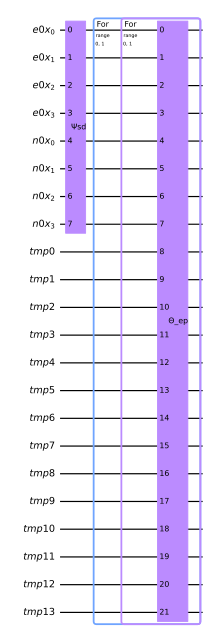

In [3]:
tev = t.get_time_evolution_block()
tev.circuit.draw(scale=0.6, style='crsq/draw_style')

an0x QuantumRegister(4, 'n0x')
quotient QuantumRegister(5, 'qq0')


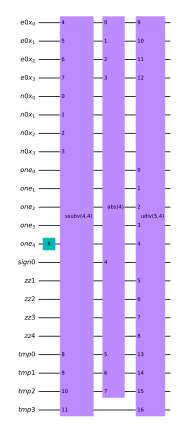

In [4]:
epb = t.get_electron_potential_block()
an0x = epb._nregs[0][0]
quotient = epb.alias_regs['elec_nucl_potential_quotient']

print("an0x", an0x)
print("quotient", quotient)
epb.circuit.draw(scale=0.4, style="crsq/draw_style")

In [5]:
from qiskit_aer import AerSimulator
from qiskit import transpile
import crsq.statevector as svec

print("get simulator")
backend = AerSimulator()

print("get circuit")
circ = t.circuit()
circ.save_statevector()
print("start transpile")
transpiled = transpile(circ, backend)
print("start run")
results = backend.run(transpiled).result()
print("get statevector")
sv = results.get_statevector()
print("write results")
svec.save_to_file(f"output/potential.csv", sv, eps=1e-12)


get simulator
get circuit
start transpile
start run
get statevector
write results


x [1, 2, 3, 0, 15, 14, 13, 4, 5, 12, 11, 6, 10, 7, 9, 8]
y [2, 2, 3, 2, 2, 2, 3, 4, 5, 4, 5, 8, 8, 16, 16, 30]


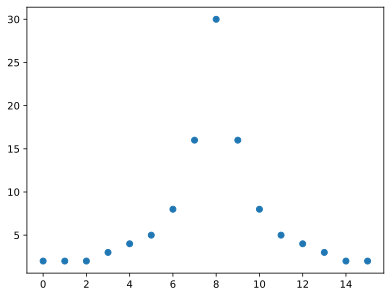

In [7]:
import crsq.statevector as svec
import matplotlib.pyplot as plt
import numpy as np

sv1 = svec.read_from_file(f"output/potential.csv")

block = t.build_elec_potential_block()

(x,y) = svec.extract_arithmetic_result_1d_scatter(block.circuit, sv1, an0x, quotient, eps=1e-12)

print("x", x)
print("y", y)
fig, ax = plt.subplots()

ax.scatter(x,y)
plt.show()
fname="output/workshop_diagrams/Ve.png"
fig.savefig(fname)